## Produce table with all collected metrics for all available configurations

In [3]:
import pandas as pd
import os
import cPickle as pickle
import matplotlib.pylab as plt
from collections import defaultdict
import re
import numpy as np
from thesis.utils.metrics import *

In [10]:
# ROOT_RESULTS_LOCATION = '/big/s/shalaby/parameter_search_doc2vec_models_new/sample_0.01/'
# ROOT_RESULTS_LOCATION = '/big/s/shalaby/parameter_search_doc2vec_models_new/full/'
ROOT_RESULTS_LOCATION = '/big/s/shalaby/extended_pv_doc2vec_svm/'
CLASSIFICATION_TYPE = 'sections'
METRICS_PNG_FILE = '{}_validation_metrics.png'
METRICS_PKL_FILE = '{}_validation_metrics.pkl'
DOC2VEC_FILES_PREFIX = 'model'
WORD2VEC_METRICS_FILE = 'word2vec_metrics.pkl'
EPOCH_PREFIX = 'epoch_{}'

DOC2VEC_MAX_EPOCHS = 20

CLASSIFICATION_SEPARATOR = ' ** '

CLASSIFICATION_TYPES_TO_USE = ['classes']
METRICS_TO_USE = ['coverage_error', 'f1_micro', 'f1_macro', 'top_3', 'top_5']
METRICS_BEST_VALUE_FUNC = {'coverage_error': np.min, 'f1_micro': np.max, 'f1_macro': np.max, 'top_3': np.max, 'top_5': np.max}
METRICS_BEST_INDEX_FUNC = {'coverage_error': np.argmin, 'f1_micro': np.argmax, 'f1_macro': np.argmax, 'top_3': np.argmax, 'top_5': np.argmax}

In [11]:
def get_subdirectories(d):
    #return filter(os.path.isdir, [f for f in os.listdir(d)])
    return [f for f in os.listdir(d) if os.path.isdir(os.path.join(d,f))]
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [12]:
get_subdirectories(ROOT_RESULTS_LOCATION)

['doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None']

In [13]:
os.listdir(ROOT_RESULTS_LOCATION)

['doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None']

In [14]:
table_rows = []
table_index = []
for doc2vec_method in natural_sort(get_subdirectories(ROOT_RESULTS_LOCATION)):
    print doc2vec_method
    epochs_path = os.path.join(ROOT_RESULTS_LOCATION, doc2vec_method)
    # this will have the structure dict of classifiers -> dict of metrics -> list of values throughout the epoch
    epoch_metrics = dict()
    epoch_word2vec_results = []
    epochs_trained = 0
    for epoch in natural_sort(get_subdirectories(epochs_path)):
        print epoch
        epochs_trained += 1
        epoch_path =  os.path.join(epochs_path, epoch)
        if os.path.exists(os.path.join(epoch_path, WORD2VEC_METRICS_FILE)):
            method_word2vec_results = pickle.load(open(os.path.join(epoch_path, WORD2VEC_METRICS_FILE), 'r'))
            epoch_word2vec_results.append(method_word2vec_results)
        for classifier in get_subdirectories(epoch_path):
            if classifier.startswith('nn'): continue
            # the values of a metric for a specific classifier throughout the epochs
            if not epoch_metrics.get(classifier): epoch_metrics[classifier] = defaultdict(list)
            
            for classf_type in CLASSIFICATION_TYPES_TO_USE:
                classifier_metrics_file = os.path.join(epoch_path, classifier, METRICS_PKL_FILE.format(classf_type))
                if os.path.exists(classifier_metrics_file):
                    classifier_metrics = pickle.load(open(classifier_metrics_file, 'r'))
                    # due to a mistake we made, some metrics files contain the whole history of metrics throughout the epochs
                    # print classifier_metrics
                    if type(classifier_metrics) is list:
                        classifier_metrics = classifier_metrics[-1]
                        pickle.dump(classifier_metrics, open(classifier_metrics_file, 'w'))
                    for metric_name in METRICS_TO_USE:
                        metric_full_name = classf_type + CLASSIFICATION_SEPARATOR + metric_name
                        epoch_metrics[classifier][metric_full_name].append(classifier_metrics[metric_name])
                        
    
    total = 0
    word2vec_epoch_correct_results = []
    for res in epoch_word2vec_results:
        total_result = [d for d in res if d['section'] == 'total'][0]
        total_correct = len(total_result['correct'])
        total_incorrect = len(total_result['incorrect'])
        if total == 0: total = total_correct + total_incorrect
        word2vec_epoch_correct_results.append(total_correct)
    best_word2vec_value = np.max(word2vec_epoch_correct_results) if len(word2vec_epoch_correct_results) else np.NaN
    best_word2vec_epoch = np.argmax(word2vec_epoch_correct_results) if len(word2vec_epoch_correct_results) else np.NaN
        
    # now that we are done with our epochs, lets figure out which epoch had the best value of every metric
    for classifier_name in sorted(epoch_metrics.keys()):
        classifier_metrics_dict = defaultdict(float)
        for metric_name in epoch_metrics[classifier_name].keys():
#             best_epoch = np.argmax(epoch_metrics[classifier_name][metric_name])
#             best_value = np.max(epoch_metrics[classifier_name][metric_name])
            just_metric = metric_name.split(CLASSIFICATION_SEPARATOR)[1]
            best_epoch = METRICS_BEST_INDEX_FUNC[just_metric](epoch_metrics[classifier_name][metric_name])
            best_value = METRICS_BEST_VALUE_FUNC[just_metric](epoch_metrics[classifier_name][metric_name])
            metric_range = abs(np.max(epoch_metrics[classifier_name][metric_name]) - np.min(epoch_metrics[classifier_name][metric_name]))
            classifier_metrics_dict[metric_name] = round(best_value, 3)
#             classifier_metrics_dict[metric_name + ' -> epoch'] = best_epoch + 1
#             classifier_metrics_dict[metric_name + ' range'] = round(metric_range, 3)

        classifier_metrics_dict['word2vec result'] = best_word2vec_value
        classifier_metrics_dict['word2vec result epoch'] = best_word2vec_epoch
        #classifier_metrics_dict['word2vec result range'] = abs(np.max(word2vec_epoch_correct_results) - np.min(word2vec_epoch_correct_results))
        classifier_metrics_dict['Epochs'] = epochs_trained

        table_rows.append(classifier_metrics_dict)
        table_index.append(doc2vec_method + ' / ' + classifier_name)


pd.set_option('display.max_colwidth',20)
        
df = pd.DataFrame(data=table_rows, index=table_index)   
df

doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None
epoch_8


,Epochs,classes ** coverage_error,classes ** f1_macro,classes ** f1_micro,classes ** top_3,classes ** top_5,word2vec result,word2vec result epoch
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_None,1,5.044,0.127,0.541,0.665,0.787,NaN,NaN
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.01_classweights_None,1,5.941,0.059,0.513,0.700,0.820,NaN,NaN
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.1_classweights_None,1,11.075,0.020,0.426,0.674,0.801,NaN,NaN


In [15]:
df.filter(regex=('.*iter_10_reg_0.001_classweights_None.*'), axis=0)\
.filter(regex='200', axis=0)
# .filter(regex='f1_micro|Epochs', axis=1)

,Epochs,classes ** coverage_error,classes ** f1_macro,classes ** f1_micro,classes ** top_3,classes ** top_5,word2vec result,word2vec result epoch
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_None,1,5.044,0.127,0.541,0.665,0.787,NaN,NaN


In [7]:
df.sort_values(by='sections ** f1_micro', ascending=False)

KeyError: 'sections ** f1_micro'

In [35]:
# df.loc[:, ['Epochs', 'subclasses ** coverage_error', 'subclasses ** f1_micro', 'subclasses ** f1_macro', 
#            'subclasses ** top_3', 'subclasses ** top_5']].filter(regex=('.*dm_concat_0.*|.*pv-dbow_concat.*'), axis=0)#.sort_values(by='sections ** f1_macro', ascending=False)
df.loc[:, ['Epochs', 'classes ** coverage_error', 'classes ** f1_micro', 'classes ** f1_macro', 
           'classes ** top_3', 'classes ** top_5']].filter(regex='.*dm_concat_0.*classweights_None|.*pv-dbow_concat.*classweights_None', axis=0)#.sort_values(by='sections ** f1_macro', ascending=False)

,Epochs,classes ** coverage_error,classes ** f1_micro,classes ** f1_macro,classes ** top_3,classes ** top_5
doc2vec_size_50_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_None,8,14.695,0.446,0.022,0.609,0.703
doc2vec_size_50_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_None,8,14.529,0.408,0.020,0.613,0.705
doc2vec_size_100_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_None,5,14.161,0.465,0.027,0.597,0.714
doc2vec_size_100_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_None,1,NaN,NaN,NaN,NaN,NaN
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_None,1,13.160,0.486,0.033,0.661,0.762
doc2vec_size_200_w_2_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_None,7,12.526,0.463,0.031,0.640,0.741
doc2vec_size_200_w_2_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.1_classweights_None,7,NaN,NaN,NaN,NaN,NaN
doc2vec_size_200_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_None,1,14.539,0.477,0.031,0.611,0.726
doc2vec_size_200_w_4_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_None,8,12.542,0.468,0.032,0.641,0.742
doc2vec_size_200_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_None,14,13.575,0.475,0.031,0.655,0.742


In [79]:
col_width = 50
df_index_list = [' '.join([name[i:i + col_width] for i in range(0, len(name), col_width)]) for name in df.index]
df.index = df_index_list
df.loc[:, ['Epochs', 'sections ** coverage_error', 'sections ** f1_micro', 'sections ** f1_macro', 'sections ** top_3']]#.sort_values(by='sections ** f1_macro', ascending=False)

,Epochs,sections ** coverage_error,sections ** f1_micro,sections ** f1_macro,sections ** top_3
doc2vec_size_50_w_8_type_dm_concat_0_mean_1_trainw ords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_re g_0.001_classweights_balanced,8,1.900,0.581,0.492,0.895
doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainw ords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_r eg_0.001_classweights_balanced,7,1.895,0.574,0.484,0.896
doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainw ords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_r eg_0.1_classweights_balanced,7,1.965,0.560,0.475,0.883
doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainw ords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_re g_0.001_classweights_balanced,7,1.897,0.574,0.484,0.896
doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainw ords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_re g_0.01_classweights_balanced,7,1.905,0.572,0.483,0.894
doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainw ords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_re g_0.1_classweights_balanced,7,1.965,0.560,0.475,0.883
doc2vec_size_50_w_8_type_pv-dbow_concat_1_mean_0_t rainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_ 10_reg_0.001_classweights_balanced,8,1.856,0.577,0.485,0.904
doc2vec_size_100_w_8_type_dm_concat_0_mean_1_train words_0_hs_0_neg_10_vocabsize_None / svm_iter_100_ reg_0.01_classweights_balanced,5,1.911,0.570,0.485,0.892
doc2vec_size_100_w_8_type_dm_concat_0_mean_1_train words_0_hs_0_neg_10_vocabsize_None / svm_iter_10_r eg_0.001_classweights_balanced,5,1.880,0.577,0.487,0.899
doc2vec_size_200_w_2_type_pv-dbow_concat_1_mean_0_ trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter _10_reg_0.001_classweights_balanced,7,1.849,0.593,0.497,0.905


In [65]:
[d['section'] for d in method_word2vec_results]

[u'capital-common-countries',
 u'capital-world',
 u'currency',
 u'city-in-state',
 u'family',
 u'gram1-adjective-to-adverb',
 u'gram2-opposite',
 u'gram3-comparative',
 u'gram4-superlative',
 u'gram5-present-participle',
 u'gram6-nationality-adjective',
 u'gram7-past-tense',
 u'gram8-plural',
 u'gram9-plural-verbs',
 'total']

In [13]:
pd.DataFrame([{'dd':2,'ee':3,'ff':4},{'dd':2,'ee':3}], index=['sdfsf','sdlfsdfsdf'])

,dd,ee,ff
sdfsf,2,3,4.0
sdlfsdfsdf,2,3,NaN


In [14]:
#direc_prefix = '/big/s/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_12_type_dm_concat_1_mean_0_trainwords_1_hs_0_neg_10_vocabsize_None_curriter_{}'
#direc_prefix = '/big/s/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_{}'
direc_prefix = '/big/s/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_0_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_{}'
import shutil
#to_delete = [8,9,10,11]
to_delete = range(15,30)

for i in to_delete:
    direc = direc_prefix.format(i)
    if os.path.exists(direc):
        model_folder_path = os.path.join(direc, "model")
        if os.path.exists(os.path.join(direc, "model.syn0.npy")):
            print "deleting {}".format(i)
            os.remove(model_folder_path)
            #os.remove(os.path.join(direc, "model.docvecs.doctag_syn0.npy"))
            os.remove(os.path.join(direc, "model.syn0.npy"))
            os.remove(os.path.join(direc, "model.syn1neg.npy"))

## Show Graph for specific configuration

In [42]:
natural_sort(get_subdirectories(ROOT_RESULTS_LOCATION))

['doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_100_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_2_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_500_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_1000_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None',
 'vocab_model']

Classifier Names

In [11]:
classifier_names = set()
for doc2vec_method in natural_sort(get_subdirectories(ROOT_RESULTS_LOCATION)):
    epochs_path = os.path.join(ROOT_RESULTS_LOCATION, doc2vec_method)
    for epoch in natural_sort(get_subdirectories(epochs_path)):
        epoch_path =  os.path.join(epochs_path, epoch)
        for subdirectory in natural_sort(get_subdirectories(epoch_path)):
            if not subdirectory.startswith(EPOCH_PREFIX):
                classifier_names.add(subdirectory)
natural_sort(classifier_names)

['svm_iter_1_reg_0.01_classweights_balanced',
 'svm_iter_10_reg_0.001_classweights_balanced',
 'svm_iter_100_reg_0.01_classweights_balanced',
 'svm_iter_100_reg_0.001_classweights_balanced']

<IPython.core.display.Javascript object>


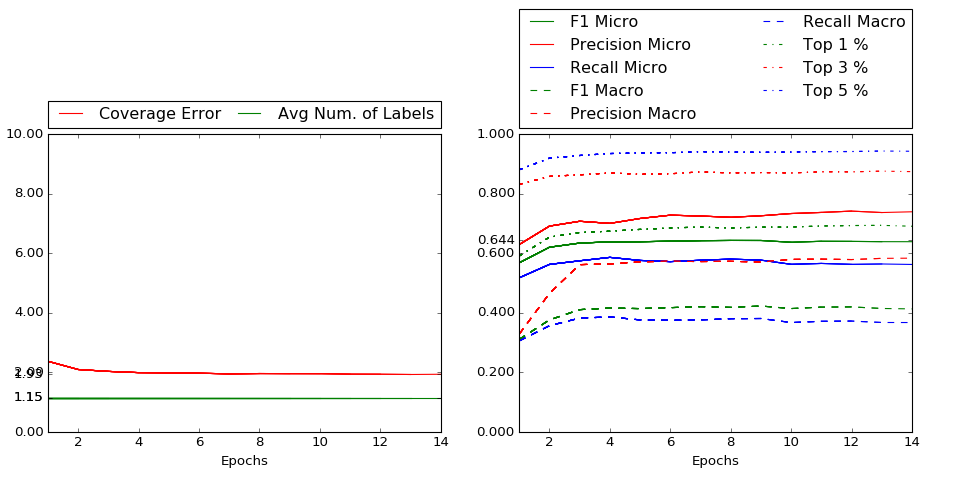

Epoch 01: Coverage Error -> 2.38, F1 Micro -> 0.569, F1 Macro -> 0.311


/home/s/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1, right=1
  'left=%s, right=%s') % (left, right))


Epoch 02: Coverage Error -> 2.10, F1 Micro -> 0.621, F1 Macro -> 0.377
Epoch 03: Coverage Error -> 2.04, F1 Micro -> 0.635, F1 Macro -> 0.411
Epoch 04: Coverage Error -> 2.00, F1 Micro -> 0.639, F1 Macro -> 0.416
Epoch 05: Coverage Error -> 1.99, F1 Micro -> 0.639, F1 Macro -> 0.415
Epoch 06: Coverage Error -> 1.98, F1 Micro -> 0.641, F1 Macro -> 0.418
Epoch 07: Coverage Error -> 1.95, F1 Micro -> 0.643, F1 Macro -> 0.421
Epoch 08: Coverage Error -> 1.96, F1 Micro -> 0.644, F1 Macro -> 0.419
Epoch 09: Coverage Error -> 1.96, F1 Micro -> 0.644, F1 Macro -> 0.423
Epoch 10: Coverage Error -> 1.96, F1 Micro -> 0.638, F1 Macro -> 0.415
Epoch 11: Coverage Error -> 1.94, F1 Micro -> 0.641, F1 Macro -> 0.420
Epoch 12: Coverage Error -> 1.94, F1 Micro -> 0.640, F1 Macro -> 0.420
Epoch 13: Coverage Error -> 1.93, F1 Micro -> 0.640, F1 Macro -> 0.415
Epoch 14: Coverage Error -> 1.94, F1 Micro -> 0.639, F1 Macro -> 0.414


In [9]:
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph()


doc2vec_approach = "doc2vec_size_200_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None"
classifier_approach = "svm_iter_10_reg_0.001_classweights_None"
classification_type = "sections"
for epoch in range(1,DOC2VEC_MAX_EPOCHS+1):
    try:
        metrics_folder = os.path.join(ROOT_RESULTS_LOCATION, doc2vec_approach, EPOCH_PREFIX.format(epoch), classifier_approach)
        #print metrics_folder
        metrics = pickle.load(open(os.path.join(metrics_folder, METRICS_PKL_FILE.format(classification_type))))
        print "Epoch {:02d}: Coverage Error -> {:.2f}, F1 Micro -> {:.3f}, F1 Macro -> {:.3f}".format(epoch, metrics['coverage_error'], metrics['f1_micro'], metrics['f1_macro'])
        graph.add_metrics_to_graph(metrics, epoch)
    except IOError as e:
        continue
#         print e
#         break

## Visualize Word2vec Results

*************** doc2vec_size_50_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


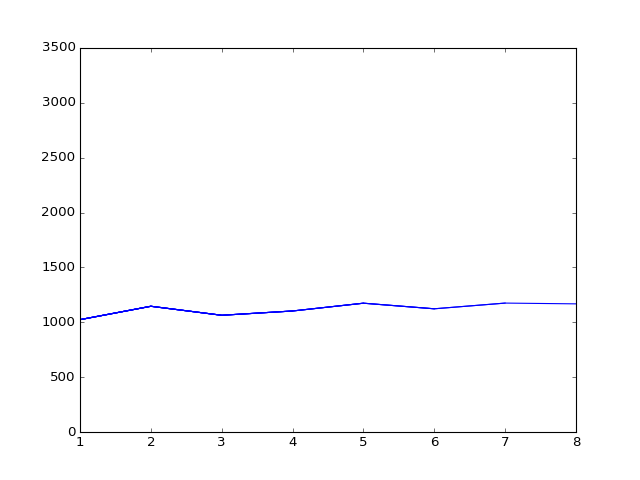

Epoch 01: Word2vec Result -> 1024.00, Syntactic: 986, Semantic: 38
Epoch 02: Word2vec Result -> 1146.00, Syntactic: 1112, Semantic: 34
Epoch 03: Word2vec Result -> 1064.00, Syntactic: 1022, Semantic: 42
Epoch 04: Word2vec Result -> 1103.00, Syntactic: 1064, Semantic: 39
Epoch 05: Word2vec Result -> 1174.00, Syntactic: 1143, Semantic: 31
Epoch 06: Word2vec Result -> 1123.00, Syntactic: 1082, Semantic: 41
Epoch 07: Word2vec Result -> 1175.00, Syntactic: 1153, Semantic: 22
Epoch 08: Word2vec Result -> 1168.00, Syntactic: 1140, Semantic: 28
*************** doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


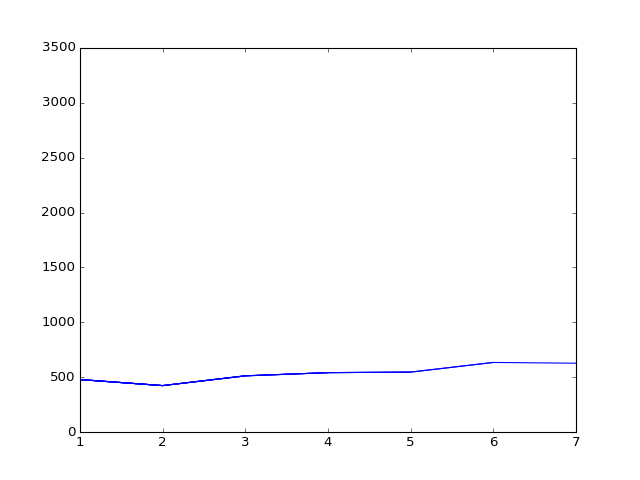

Epoch 01: Word2vec Result -> 478.00, Syntactic: 445, Semantic: 33
Epoch 02: Word2vec Result -> 423.00, Syntactic: 403, Semantic: 20
Epoch 03: Word2vec Result -> 512.00, Syntactic: 494, Semantic: 18
Epoch 04: Word2vec Result -> 541.00, Syntactic: 507, Semantic: 34
Epoch 05: Word2vec Result -> 546.00, Syntactic: 514, Semantic: 32
Epoch 06: Word2vec Result -> 634.00, Syntactic: 604, Semantic: 30
Epoch 07: Word2vec Result -> 627.00, Syntactic: 596, Semantic: 31
*************** doc2vec_size_50_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


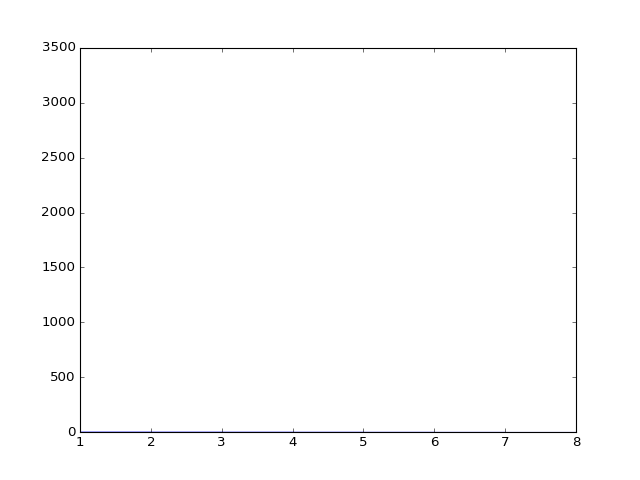

Epoch 01: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 02: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 03: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 04: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 05: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 06: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 07: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 08: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
*************** doc2vec_size_100_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


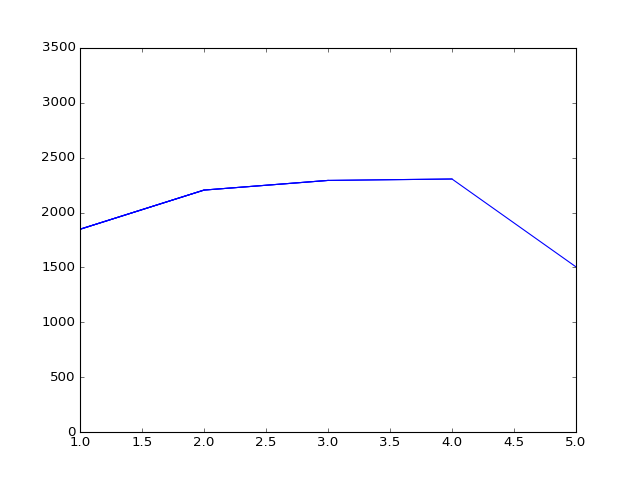

Epoch 01: Word2vec Result -> 1848.00, Syntactic: 1751, Semantic: 97
Epoch 02: Word2vec Result -> 2205.00, Syntactic: 2082, Semantic: 123
Epoch 03: Word2vec Result -> 2293.00, Syntactic: 2142, Semantic: 151
Epoch 04: Word2vec Result -> 2306.00, Syntactic: 2142, Semantic: 164
Epoch 05: Word2vec Result -> 1505.00, Syntactic: 1378, Semantic: 127
*************** doc2vec_size_200_w_2_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


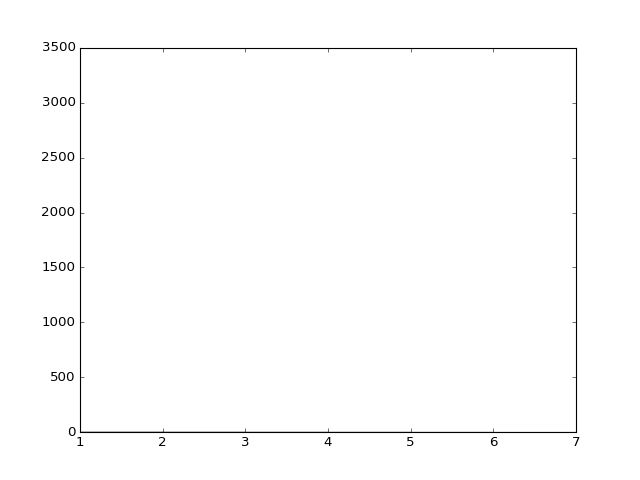

Epoch 01: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 02: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 03: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 04: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 05: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 06: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 07: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
*************** doc2vec_size_200_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


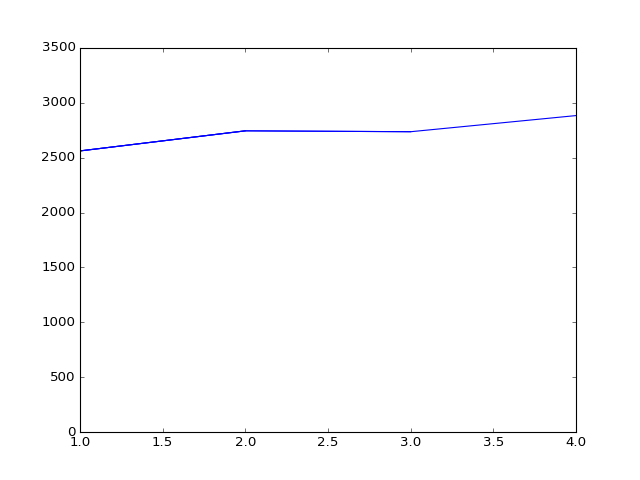

Epoch 01: Word2vec Result -> 2562.00, Syntactic: 2366, Semantic: 196
Epoch 02: Word2vec Result -> 2745.00, Syntactic: 2551, Semantic: 194
Epoch 03: Word2vec Result -> 2737.00, Syntactic: 2584, Semantic: 153
Epoch 04: Word2vec Result -> 2884.00, Syntactic: 2728, Semantic: 156
*************** doc2vec_size_200_w_4_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


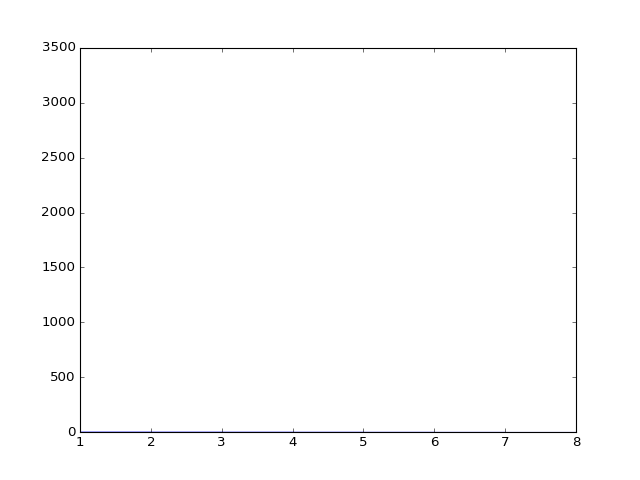

Epoch 01: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 02: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 03: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 04: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 05: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 06: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 07: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 08: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
*************** doc2vec_size_200_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


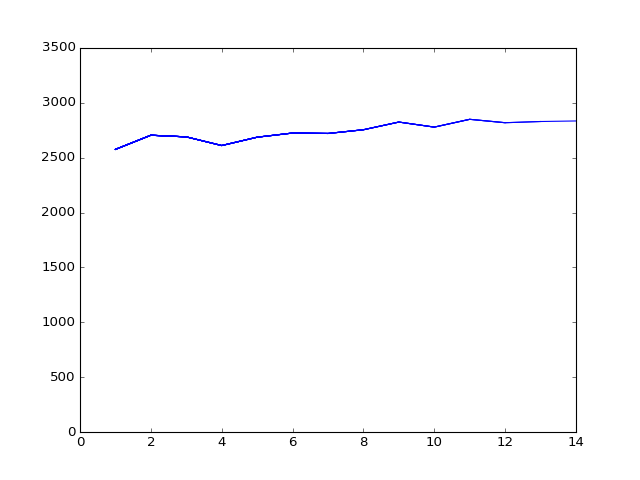

Epoch 01: Word2vec Result -> 2576.00, Syntactic: 2405, Semantic: 171
Epoch 02: Word2vec Result -> 2705.00, Syntactic: 2555, Semantic: 150
Epoch 03: Word2vec Result -> 2690.00, Syntactic: 2573, Semantic: 117
Epoch 04: Word2vec Result -> 2611.00, Syntactic: 2476, Semantic: 135
Epoch 05: Word2vec Result -> 2687.00, Syntactic: 2574, Semantic: 113
Epoch 06: Word2vec Result -> 2725.00, Syntactic: 2591, Semantic: 134
Epoch 07: Word2vec Result -> 2721.00, Syntactic: 2618, Semantic: 103
Epoch 08: Word2vec Result -> 2755.00, Syntactic: 2658, Semantic: 97
Epoch 09: Word2vec Result -> 2825.00, Syntactic: 2719, Semantic: 106
Epoch 10: Word2vec Result -> 2779.00, Syntactic: 2674, Semantic: 105
Epoch 11: Word2vec Result -> 2850.00, Syntactic: 2734, Semantic: 116
Epoch 12: Word2vec Result -> 2819.00, Syntactic: 2715, Semantic: 104
Epoch 13: Word2vec Result -> 2830.00, Syntactic: 2720, Semantic: 110
Epoch 14: Word2vec Result -> 2835.00, Syntactic: 2726, Semantic: 109
*************** doc2vec_size_200_w_

<IPython.core.display.Javascript object>


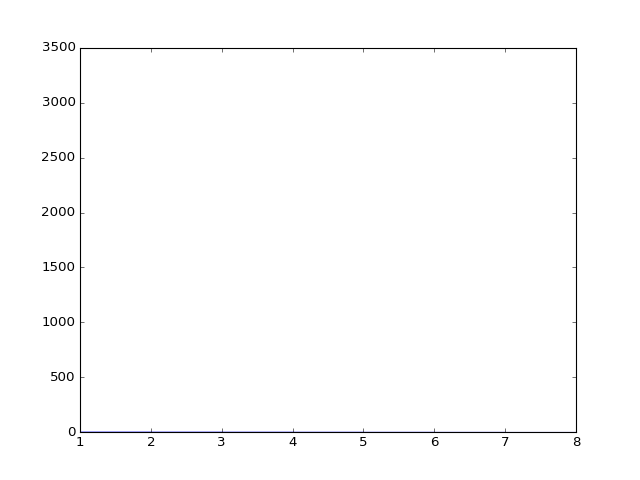

Epoch 01: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 02: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 03: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 04: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 05: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 06: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 07: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 08: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
*************** doc2vec_size_200_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


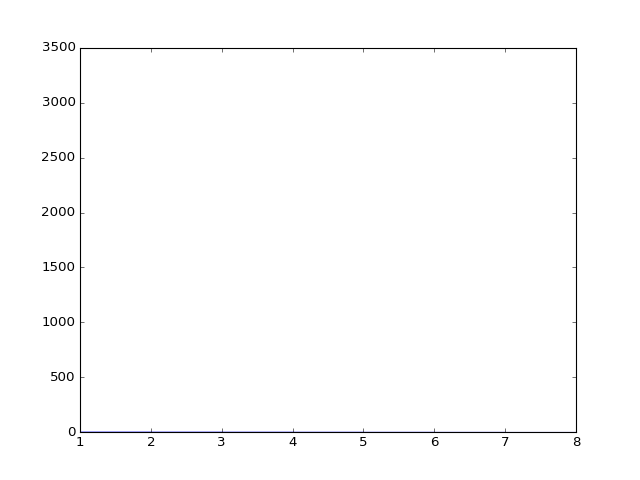

Epoch 01: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 02: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 03: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 04: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 05: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 06: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 07: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 08: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
*************** doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


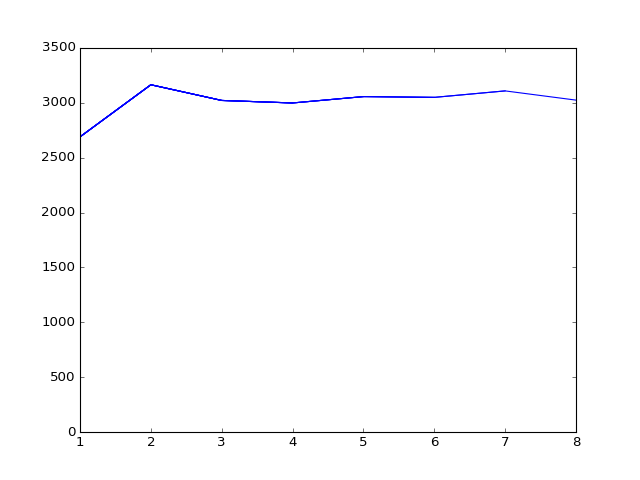

Epoch 01: Word2vec Result -> 2690.00, Syntactic: 2501, Semantic: 189
Epoch 02: Word2vec Result -> 3165.00, Syntactic: 2943, Semantic: 222
Epoch 03: Word2vec Result -> 3022.00, Syntactic: 2813, Semantic: 209
Epoch 04: Word2vec Result -> 2999.00, Syntactic: 2811, Semantic: 188
Epoch 05: Word2vec Result -> 3057.00, Syntactic: 2911, Semantic: 146
Epoch 06: Word2vec Result -> 3050.00, Syntactic: 2877, Semantic: 173
Epoch 07: Word2vec Result -> 3109.00, Syntactic: 2949, Semantic: 160
Epoch 08: Word2vec Result -> 3025.00, Syntactic: 2880, Semantic: 145
*************** doc2vec_size_500_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


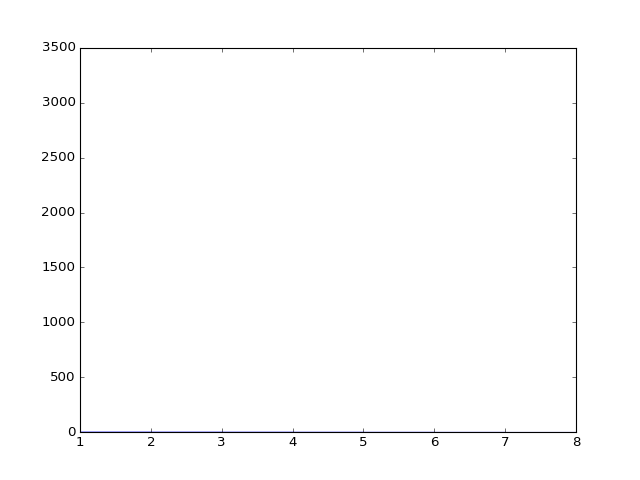

Epoch 01: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 02: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 03: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 04: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 05: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 06: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 07: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 08: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
*************** doc2vec_size_1000_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


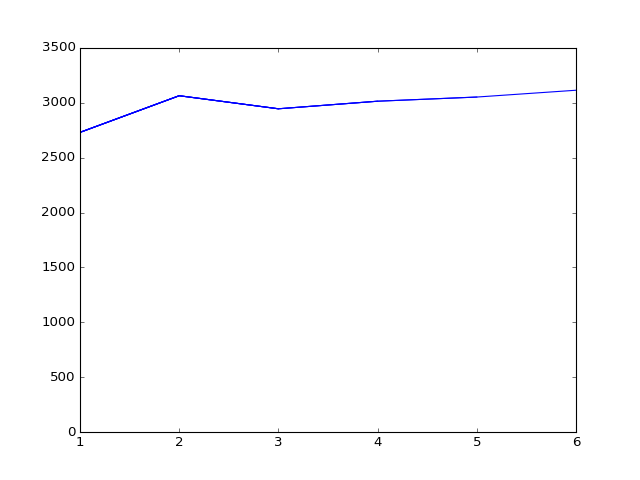

Epoch 01: Word2vec Result -> 2731.00, Syntactic: 2491, Semantic: 240
Epoch 02: Word2vec Result -> 3065.00, Syntactic: 2828, Semantic: 237
Epoch 03: Word2vec Result -> 2946.00, Syntactic: 2761, Semantic: 185
Epoch 04: Word2vec Result -> 3015.00, Syntactic: 2849, Semantic: 166
Epoch 05: Word2vec Result -> 3053.00, Syntactic: 2861, Semantic: 192
Epoch 06: Word2vec Result -> 3115.00, Syntactic: 2927, Semantic: 188
*************** vocab_model


<IPython.core.display.Javascript object>


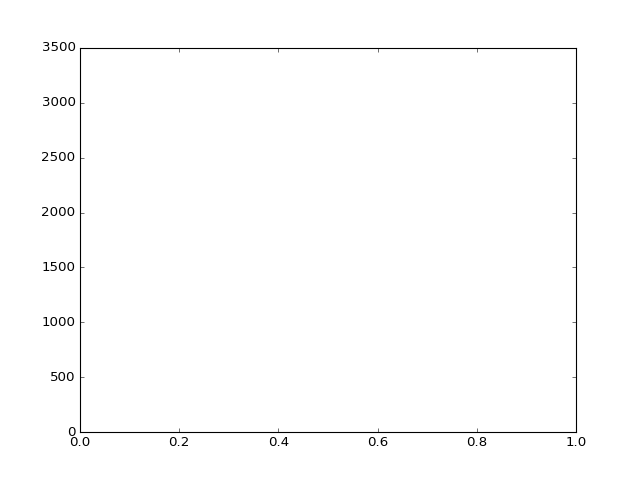

In [8]:
%matplotlib notebook
for doc2vec_approach in natural_sort(get_subdirectories(ROOT_RESULTS_LOCATION)):

    print "*************** {}".format(doc2vec_approach)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.set_ylim([0,3500])
    word2vec_results = []
    for epoch in range(1,DOC2VEC_MAX_EPOCHS+1):
        try:
            method_word2vec_results = pickle.load(open(os.path.join(ROOT_RESULTS_LOCATION, doc2vec_approach, EPOCH_PREFIX.format(epoch), WORD2VEC_METRICS_FILE), 'r'))
            total_result = [d for d in method_word2vec_results if d['section'] == 'total'][0]
            total_correct = len(total_result['correct'])
            word2vec_results.append(total_correct)
            
            syntactic_results = [d for d in method_word2vec_results if d['section'].startswith('gram')]
            semantic_results = [d for d in method_word2vec_results if not d['section'].startswith('gram') and d['section'] != 'total']
            syntactic_total_correct = sum([len(res['correct']) for res in syntactic_results])
            semantic_total_correct = sum([len(res['correct']) for res in semantic_results])
            #print "Epoch {:02d}: Coverage Error -> {:.2f}".format(epoch, metrics['coverage_error'])
            print "Epoch {:02d}: Word2vec Result -> {:.2f}, Syntactic: {}, Semantic: {}".format(epoch, total_correct, syntactic_total_correct, semantic_total_correct)
            ax.plot(range(1,epoch+1), word2vec_results, 'b')
            fig.canvas.draw()
        except IOError:
            break